<a href="https://colab.research.google.com/github/GMdSilva/gms_natcomms_1705932980_data/blob/main/AlphaFold2_Traj_multimer_v0_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prediction of protein conformational distributions with subsampled AlphaFold2**


This Jupyter notebook presents an innovative approach for predicting the relative populations of protein conformations using AlphaFold 2 (AF2). Here, we are going to set up a protocol to subsample multiple sequence alignments and generate ensembles of protein conformations and test AF2's capacity to predict sequence-induced differences in the conformational distributions of the Abl1 tyrosine kinase. This notebook is a supplementary material of the paper "***High-throughput prediction of protein conformational distributions with subsampled AlphaFold2***" ([link here](https://doi.org/10.1038/s41467-024-46715-9)) and we encourage you to read it before using this pipeline.

Scripts used to assemble the MSAs and run AlphaFold2 with different subsampling conditions have been deposited in the GitHub repository https://github.com/GMdSilva/gms_natcomms_1705932980_data

The main goal of this notebook is to demonstrate how AlphaFold 2 can directly predict the relative populations of different protein conformations by subsampling multiple sequence alignments


A work by **Gabriel Monteiro da Silva**, **Jennifer Y. Cui**, **David C. Dalgarno**, **George P. Lisi** and **Brenda M. Rubenstein**.

Jupyter Notebook created by **Gabriel Monteiro da Silva** ([@GMondaSilva](https://twitter.com/GMondaSilva)) and **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes)).


---

**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/GMdSilva/gms_natcomms_1705932980_data/issues

**Changelog**

-  **v1.0.1**
 - Added feature to disable mmseqs2 PCA filtering
 - Fixed critical error with *pca_sel* reference

**Acknowledgments**

- We would like to thank the AlphaFold team for developing an excellent model and open sourcing the software.

- [Söding Lab](https://www.mpibpc.mpg.de/soeding) for providing the computational resources for the MMseqs2 server

- Credit to Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)) for their fantastic [ColabFold](https://github.com/sokrypton/ColabFold)

- We would like to thank [Making it rain](https://github.com/pablo-arantes/making-it-rain) team, **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes)), **Marcelo D. Polêto** ([@mdpoleto](https://twitter.com/mdpoleto)), **Conrado Pedebos** ([@ConradoPedebos](https://twitter.com/ConradoPedebos)) and **Rodrigo Ligabue-Braun** ([@ligabue_braun](https://twitter.com/ligabue_braun)), for their amazing work. The present notebook was strongly inspired on Making it rain idea.

# **Introduction**

For inputs, you will need:
*  An amino acid sequence of your protein
*  A PDB file containing a reference conformation of your protein (optional)

In this notebook, we will test the accuracy of different AF2 subsampling parameter combinations to predict the structural plasticity of Abl1 activation loop conformations.

We chose the Abl1 kinase core for our test case due to this protein's [extensively documented](https://www.science.org/doi/10.1126/science.abc2754) dynamics and relative state populations.

## **Using Google Drive to store the data**

Google Colab does not allow users to keep data on their computing nodes. \

However, we can use Google Drive to read, write, and store our files. \

Therefore, we suggest to you to:

-  Copy the path of your created directory. We will use it below.

In [ ]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" button to make your Google Drive accessible.
from pydrive2.drive import GoogleDrive
from pydrive2.auth import GoogleAuth
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#@title **Check if GPU nodes were correctly allocated**

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Apr  3 04:57:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
%%capture
#@title **Install dependencies**
#@markdown This might take a few minutes.
# install dependencies

import sys
import os
import subprocess

commands = [
    "pip install MDAnalysis",
    "pip install py3dmol",
    "pip install -U matplotlib"
]

for cmd in commands:
    subprocess.run(cmd, shell=True)


#@title setup
unified_memory = True #@param {type:"boolean"}
import os, time, gc
if unified_memory:
  ENV = {"TF_FORCE_UNIFIED_MEMORY":"1", "XLA_PYTHON_CLIENT_MEM_FRACTION":"4.0"}
  for k,v in ENV.items(): os.environ[k] = v
if not os.path.isdir("params"):
  # get code
  print("installing ColabDesign")
  os.system("(mkdir params; apt-get install aria2 -qq; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar; \
  tar -xf alphafold_params_2022-12-06.tar -C params; touch params/done.txt )&")

  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@gamma")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")
  os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/main/colabfold/colabfold.py -O colabfold_utils.py")
  #os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/beta/colabfold/mmseqs/api.py")

  # install hhsuite
  print("installing HHsuite")
  os.makedirs("hhsuite", exist_ok=True)
  os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C hhsuite/")

  # download params
  if not os.path.isfile("params/done.txt"):
    print("downloading AlphaFold params")
    while not os.path.isfile("params/done.txt"):
      time.sleep(5)
if "hhsuite" not in os.environ['PATH']:
  os.environ['PATH'] += ":hhsuite/bin:hhsuite/scripts"

import re, tempfile
from IPython.display import HTML
from google.colab import files
import numpy as np
from colabdesign import mk_af_model, clear_mem
from colabdesign.af.contrib import predict
from colabdesign.af.contrib.cyclic import add_cyclic_offset
from colabdesign.shared.protein import _np_rmsd, _np_kabsch
from colabdesign.shared.plot import plot_pseudo_3D, pymol_cmap


import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import string
import numpy as np

def clear_mem():
  backend = jax.lib.xla_bridge.get_backend()
  for buf in backend.live_buffers(): buf.delete()

def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    os.makedirs("tmp",exist_ok=True)
    os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.cif -P tmp/")
    return f"tmp/{pdb_code}.cif"
  else:
    os.makedirs("tmp",exist_ok=True)
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v4.pdb -P tmp/")
    return f"tmp/AF-{pdb_code}-F1-model_v4.pdb"

def run_hhalign(query_sequence, target_sequence, query_a3m=None, target_a3m=None):
  with tempfile.NamedTemporaryFile() as tmp_query, \
  tempfile.NamedTemporaryFile() as tmp_target, \
  tempfile.NamedTemporaryFile() as tmp_alignment:
    if query_a3m is None:
      tmp_query.write(f">Q\n{query_sequence}\n".encode())
      tmp_query.flush()
      query_a3m = tmp_query.name
    if target_a3m is None:
      tmp_target.write(f">T\n{target_sequence}\n".encode())
      tmp_target.flush()
      target_a3m = tmp_target.name
    os.system(f"hhalign -hide_cons -i {query_a3m} -t {target_a3m} -o {tmp_alignment.name}")
    X, start_indices = predict.parse_hhalign_output(tmp_alignment.name)
  return X, start_indices

def run_do_not_align(query_sequence, target_sequence, **arg):
  return [query_sequence,target_sequence],[0,0]

def run_hhfilter(input, output, id=90, qid=10):
  os.system(f"hhfilter -id {id} -qid {qid} -i {input} -o {output}")

@jax.jit
def get_coevolution(X):
  '''given one-hot encoded MSA, return contacts'''
  Y = jax.nn.one_hot(X,22)
  N,L,A = Y.shape
  Y_flat = Y.reshape(N,-1)
  # covariance
  c = jnp.cov(Y_flat.T)

  # inverse covariance
  shrink = 4.5/jnp.sqrt(N) * jnp.eye(c.shape[0])
  ic = jnp.linalg.inv(c + shrink)

  # partial correlation coefficient
  ic_diag = jnp.diag(ic)
  pcc = ic / jnp.sqrt(ic_diag[:,None] * ic_diag[None,:])

  raw = jnp.sqrt(jnp.square(pcc.reshape(L,A,L,A)[:,:20,:,:20]).sum((1,3)))
  i = jnp.arange(L)
  raw = raw.at[i,i].set(0)
  # do apc
  ap = raw.sum(0,keepdims=True) * raw.sum(1,keepdims=True) / raw.sum()
  return (raw - ap).at[i,i].set(0)

def plot_3D(aux, Ls, file_name, show=False):
  plt.figure(figsize=(10,5))
  xyz = aux["atom_positions"][:,1]
  xyz = xyz @ _np_kabsch(xyz, xyz, return_v=True, use_jax=False)
  ax = plt.subplot(1,2,1)
  if len(Ls) > 1:
    plt.title("chain")
    c = np.concatenate([[n]*L for n,L in enumerate(Ls)])
    plot_pseudo_3D(xyz=xyz, c=c, cmap=pymol_cmap, cmin=0, cmax=39, Ls=Ls, ax=ax)
  else:
    plt.title("length")
    plot_pseudo_3D(xyz=xyz, Ls=Ls, ax=ax)
  plt.axis(False)
  ax = plt.subplot(1,2,2)
  plt.title("plddt")
  plot_pseudo_3D(xyz=xyz, c=aux["plddt"], cmin=0.5, cmax=0.9, Ls=Ls, ax=ax)
  plt.axis(False)
  plt.savefig(file_name, dpi=200, bbox_inches='tight')
  plt.show() if show else plt.close()

In [ ]:
#@title **Disable MSA filtering?**
disable_mmseqs2_filtering = False #@param {type:"boolean"}
#@markdown - Disabling filtering leads to deeper MSAs (generally)
#@markdown - For Abl1, deeper MSAs lead to more diverse ensembles
#@markdown - However, deep MSAs also increase computing time, so for this example we keep filtering enabled
#@markdown - We recommend comparing results with and without filtering


#@markdown **You will need to restart the kernel and re-run "Install dependencies" after changing filtering options**

def disable_filtering(file_path, original_line, new_line):
    try:
        with open(file_path, 'r') as file:
            content = file.readlines()
    except IOError as e:
        return f"Error opening file: {e}"

    modified = False
    for i, line in enumerate(content):
        if original_line in line:
            content[i] = new_line + '\n'
            modified = True
            break

    if modified:
        try:
            with open(file_path, 'w') as file:
                file.writelines(content)
            return "Successfully altered mmseqs2 MSA filtering."
        except IOError as e:
            return f"Error writing file: {e}"

file_path = "colabfold_utils.py"

if disable_mmseqs2_filtering:
  original_line = "def run_mmseqs2(x, prefix, use_env=True, use_filter=True,"
  new_line = "def run_mmseqs2(x, prefix, use_env=True, use_filter=False,"
  result = disable_filtering(file_path, original_line, new_line)
  print(result)
else:
  original_line = "def run_mmseqs2(x, prefix, use_env=True, use_filter=False,"
  new_line = "def run_mmseqs2(x, prefix, use_env=True, use_filter=True,"
  result = disable_filtering(file_path, original_line, new_line)
  print(result)

None


jobname Abl1_8967d_1
length=[252] copies=1
getting unpaired MSA


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:02 remaining: 00:00]


parsing msas


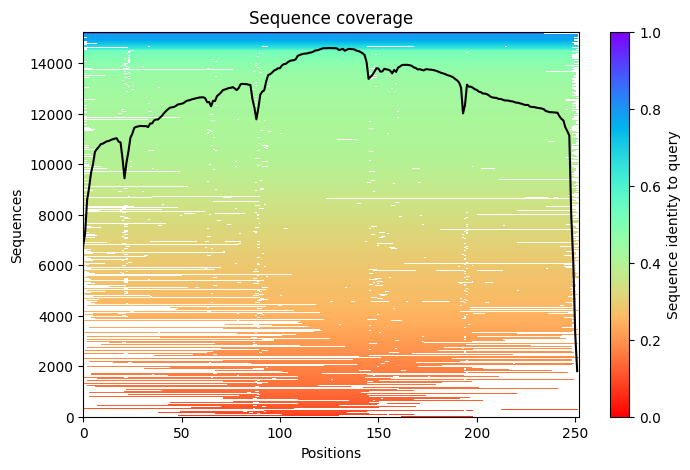

5969

In [ ]:
#@title **Build MSA**

sequence = "ITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAF" #@param {type:"string"}
jobname = "Abl1" #@param {type:"string"}

#@markdown - You can predict multimers by separating sequences with '':'' (e.g. ''ABC...**:**DFG...'')
#@markdown - This notebook has **not yet been tested** for multimeter predictions

copies = 1 #@param
#@markdown ----
msa_method = "mmseqs2"
pair_mode = "unpaired_paired"
do_not_filter = True
#@markdown Save MSA features plot to Google Drive?
save_to_google_drive = True #@param {type:"boolean"}
cov = 70
id = 70
qid = 0

#@markdown - This cell has been mostly grafted from CollabFold's [AlphaFold2_advanced_v2 Notebook](https://colab.research.google.com/github/sokrypton/ColabDesign/blob/gamma/af/examples/predict.ipynb)
#@markdown - All credits to the original authors ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger))


template_mode = "none"
use_templates = template_mode in ["mmseqs2","custom"]
pdb = ""
chain = "A"
rm_template_seq = False
propagate_to_copies = True
do_not_align = False
rm_sidechain = rm_sequence = rm_template_seq

# filter options
sequence = sequence.upper()
sequence = re.sub("[^A-Z:/()]", "", sequence.upper())
sequence = re.sub("\(",":(", sequence)
sequence = re.sub("\)","):", sequence)
sequence = re.sub(":+",":",sequence)
sequence = re.sub("/+","/",sequence)
sequence = re.sub("^[:/]+","",sequence)
sequence = re.sub("[:/]+$","",sequence)
jobname = re.sub(r'\W+', '', jobname)

# process sequence
sequences = sequence.split(":")
u_sequences = predict.get_unique_sequences(sequences)
u_cyclic = [x.startswith("(") for x in u_sequences]
u_sub_lengths = [[len(y) for y in x.split("/")] for x in u_sequences]
u_sequences = [x.replace("(","").replace(")","").replace("/","") for x in u_sequences]
if len(sequences) > len(u_sequences):
  print("WARNING: use copies to define homooligomers")
u_lengths = [len(x) for x in u_sequences]
sub_seq = "".join(u_sequences)
seq = sub_seq * copies

from colabfold_utils import run_mmseqs2

jobname = f"{jobname}_{predict.get_hash(seq)[:5]}"
def check(folder): return os.path.exists(folder)
if check(jobname):
  n = 0
  while check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

print("jobname",jobname)
print(f"length={u_lengths} copies={copies}")

input_opts = {"sequence":u_sequences,
              "copies":copies,
              "msa_method":msa_method,
              "pair_mode":pair_mode,
              "do_not_filter":do_not_filter,
              "cov":cov,
              "id":id,
              "template_mode":template_mode,
              "propagate_to_copies":propagate_to_copies}

def run_mmseqs2_wrapper(*args, **kwargs):
  kwargs['user_agent'] = "colabdesign/gamma"
  return run_mmseqs2(*args, **kwargs)

##################
# GET MSA
##################
os.makedirs(jobname, exist_ok=True)

Ls = [len(x) for x in u_sequences]
if msa_method == "mmseqs2":
  msa, deletion_matrix = predict.get_msa(u_sequences, jobname,
    mode=pair_mode,
    cov=cov, id=id, qid=qid, max_msa=4096,
    do_not_filter=do_not_filter,
    mmseqs2_fn=run_mmseqs2_wrapper,
    hhfilter_fn=run_hhfilter)

elif msa_method == "single_sequence":
  with open(f"{jobname}/msa.a3m","w") as a3m:
    a3m.write(f">{jobname}\n{sub_seq}\n")
  msa, deletion_matrix = predict.parse_a3m(f"{jobname}/msa.a3m")

else:
  msa_format = msa_method.split("_")[1]
  print(f"upload {msa_method}")
  msa_dict = files.upload()
  lines = []
  for k,v in msa_dict.items():
    lines += v.decode().splitlines()
  input_lines = []
  for line in lines:
    line = line.replace("\x00","")
    if len(line) > 0 and not line.startswith('#'):
      input_lines.append(line)
  with open(f"{jobname}/msa.{msa_format}","w") as msa:
    msa.write("\n".join(input_lines))
  if msa_format != "a3m":
    os.system(f"perl hhsuite/scripts/reformat.pl {msa_format} a3m {jobname}/msa.{msa_format} {jobname}/msa.a3m")
  if do_not_filter:
    os.system(f"hhfilter -qid 0 -id 100 -cov 0 -i {jobname}/msa.a3m -o {jobname}/msa.filt.a3m")
  else:
    os.system(f"hhfilter -qid {qid} -id {id} -cov {cov} -i {jobname}/msa.a3m -o {jobname}/msa.filt.a3m")
  msa, deletion_matrix = predict.parse_a3m(f"{jobname}/msa.filt.a3m")

if len(msa) > 1:
  predict.plot_msa(msa, Ls)
  plt.savefig(f"{jobname}/msa_feats.png", dpi=200, bbox_inches='tight')
  plt.show()

##################
if use_templates:
  print("aligning template")
  template_msa = f"{jobname}/msa.a3m"
  if template_mode == "mmseqs2":
    predict.get_msa(u_sequences, jobname,
      mode="unpaired",
      mmseqs2_fn=run_mmseqs2_wrapper,
      do_not_filter=True,
      do_not_return=True,
      output_a3m=f"{jobname}/msa_tmp.a3m")
    template_msa = f"{jobname}/msa_tmp.a3m"
    if not propagate_to_copies and copies > 1:
      new_msa = []
      with open(template_msa, "r") as handle:
        for line in handle:
          if not line.startswith(">"):
            new_msa.append(line.rstrip())
      with open(template_msa, "w") as handle:
        for n,seq in enumerate(new_msa):
          handle.write(f">{n}\n{seq*copies}\n")

    templates = {}
    print("ID\tpdb\tcid\tevalue")
    for line in open(f"{jobname}/msa/_env/pdb70.m8","r"):
      p = line.rstrip().split()
      M,target_id,qid,e_value = p[0],p[1],p[2],p[10]
      M = int(M)
      if M not in templates:
        templates[M] = []
      if len(templates[M]) < 4:
        print(f"{int(M)}\t{target_id}\t{qid}\t{e_value}")
        templates[M].append(target_id)
    if len(templates) == 0:
      use_templates = False
      print("ERROR: no templates found...")
    else:
      Ms = sorted(list(templates.keys()))
      pdbs,chains = [],[]
      for M in Ms:
        for n,target_id in enumerate(templates[M]):
          pdb_id,chain_id = target_id.split("_")
          if len(pdbs) < n+1:
            pdbs.append([])
            chains.append([])
          pdbs[n].append(pdb_id)
          chains[n].append(chain_id)
      print(pdbs)
  else:
    pdbs,chains = [pdb],[chain]

if use_templates:
  input_opts.update({"pdbs":pdbs, "chains":chains})
  batches = []
  for pdb,chain in zip(pdbs,chains):
    query_seq = "".join(u_sequences)
    batch = predict.get_template_feats(pdb, chain,
      query_seq=query_seq,
      query_a3m=template_msa,
      copies=copies,
      propagate_to_copies=propagate_to_copies,
      use_seq=not rm_sequence,
      get_pdb_fn=get_pdb,
      align_fn=run_do_not_align if do_not_align else run_hhalign)
    batches.append(batch)

  # for display
  plt.figure(figsize=(3*len(batches),3))
  for n,batch in enumerate(batches):
    plt.subplot(1,len(batches),n+1)
    plt.title(f"template features {n+1}")
    dgram = batch["dgram"].argmax(-1).astype(float)
    dgram[batch["dgram"].sum(-1) == 0] = np.nan
    Ln = dgram.shape[0]
    plt.imshow(dgram, extent=(0, Ln, Ln, 0))
    predict.plot_ticks(Ls * copies)
  plt.savefig(f"{jobname}/template_feats.png", dpi=200, bbox_inches='tight')
  plt.show()
else:
  batches = [None]

################
gc.collect()

In [ ]:
#@title **Set subsampling ranges**
#@markdown **First subsampling range:**
max_seq1 = "8" #@param ["2048", "1024", "512", "256", "128", "64", "32", "16", "8", "4", "2"]
extra_seq1 = "16" #@param ["2048", "1024", "512", "256", "128", "64", "32", "16", "8", "4", "2"]
#@markdown **Second subsampling range:**
max_seq2 = "32" #@param ["2048", "1024", "512", "256", "128", "64", "32", "16", "8", "4", "2"]
extra_seq2 = "64" #@param ["2048", "1024", "512", "256", "128", "64", "32", "16", "8", "4", "2"]
#@markdown **Third subsampling range:**
max_seq3 = "256" #@param ["2048", "1024", "512", "256", "128", "64", "32", "16", "8", "4", "2"]
extra_seq3 = "512" #@param ["2048", "1024", "512", "256", "128", "64", "32", "16", "8", "4", "2"]


#@markdown - For an explanation of the effects of changing *max_seq*/*extra_seq*, check Figure 2 of our paper

max_seq = [max_seq1, max_seq2, max_seq3]
extra_seq = [extra_seq1, extra_seq2, extra_seq3]

print("max_seq:extra_seq pairs")
for extra_seq_v, max_seq_v in zip(extra_seq, max_seq):
  print(f"{max_seq_v}:{extra_seq_v}")

max_seq:extra_seq pairs
8:16
32:64
256:512


In [ ]:
%%time
#@title **Run subsampled AlphaFold2**
for max_seq_v, extra_seq_v in zip(max_seq, extra_seq):
  #@markdown ###**General options:**
  model_type = "auto" #@param ["monomer (ptm)", "pseudo_multimer (v3)", "multimer (v3)", "auto"]
  rank_by = "auto" #@param ["auto", "plddt", "ptm"]
  debug = False
  max_msa_depth = 60000 #@param {type:"slider", min:5000, max:1000000, step:5000}
  #@markdown - If the kernel crashes due lack of RAM, try reducing *max_msa_depth*
  use_initial_guess = False
  use_cluster_profile = False
  #@markdown - Currently, this notebook has only been tested for monomer predictions

#@markdown ----

  if model_type == "monomer (ptm)":
    use_multimer = False
    pseudo_multimer = False
  elif model_type == "multimer (v3)":
    use_multimer = True
    pseudo_multimer = False
  elif model_type == "pseudo_multimer (v3)":
    use_multimer = True
    pseudo_multimer = True
  elif len(u_lengths) > 1 or copies > 1:
    use_multimer = True
    pseudo_multimer = False
  else:
    use_multimer = False
    pseudo_multimer = False

  if rank_by == "auto":
    rank_by = "multi" if (len(u_lengths) > 1 or copies > 1) else "plddt"

  model_opts = {"num_msa":int(max_seq_v),
                "num_extra_msa":int(extra_seq_v),
                "num_templates":len(batches),
                "use_cluster_profile":use_cluster_profile,
                "use_multimer":use_multimer,
                "pseudo_multimer":pseudo_multimer,
                "use_templates":use_templates,
                "use_batch_as_template":False,
                "use_dgram":True,
                "protocol":"hallucination",
                "best_metric":rank_by,
                "optimize_seq":False,
                "debug":debug,
                "clear_prev":False}

  # initialize the model
  if "af" in dir():
    # reuse the model and/or params if already initialized
    if model_opts != model_opts_:
      if model_opts["use_multimer"] == af._args["use_multimer"] \
      and model_opts["use_templates"] == af._args["use_templates"]:
        old_params = dict(zip(af._model_names,af._model_params))
      else:
        print("loading alphafold params")
        old_params = {}
        clear_mem()
      af = mk_af_model(old_params=old_params,
                      use_mlm=True, # can be disabled later with 0% masking
                      **model_opts)
      model_opts_ = predict.copy_dict(model_opts)
  else:
    print("loading alphafold params")
    af = mk_af_model(use_mlm=True,
                    **model_opts)
    model_opts_ = predict.copy_dict(model_opts)

  # prep inputs
  af.prep_inputs(u_lengths, copies=copies, seed=0)
  print_key = ["plddt","ptm"]
  if len(af._lengths) > 1: print_key += ["i_ptm", "multi"]

  # for contact map
  af.set_opt("con",cutoff=8.0)

  # set templates
  if use_templates:

    # interchain masking determined by dgram
    af._inputs["interchain_mask"] = np.full_like(af._inputs["interchain_mask"],True)

    af.set_opt(use_initial_guess=use_initial_guess)
    for n,batch in enumerate(batches):
      af.set_template(batch=batch, n=n)
    af.set_opt("template",
              rm_sc=rm_sidechain,
              rm_seq=rm_sequence)
  # potentially filter MSA to save ram memory
  msa_f = msa[:max_msa_depth]
  # set msa
  af.set_msa(msa_f, deletion_matrix)

  # set chainbreaks
  L_prev = 0
  for n,l in enumerate(u_sub_lengths * copies):
    for L_i in l[:-1]:
      af._inputs["residue_index"][L_prev+L_i:] += 32
      L_prev += L_i
    L_prev += l[-1]

  # set cyclic constraints
  i_cyclic = [n for n, c in enumerate(u_cyclic * copies) if c]
  if len(i_cyclic) > 0:
    add_cyclic_offset(af,i_cyclic)

  #@markdown ###**Model options:**
  model = "all" #@param ["1", "2", "3", "4", "5", "all"]
  num_recycles = 3 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
  recycle_early_stop_tolerance = 0.0 #@param ["0.0", "0.5", "1.0"] {type:"raw"}
  select_best_across_recycles = False #@param {type:"boolean"}
  use_mlm = False
  use_dropout = True
  #@markdown Define first seed (for reproducibility):
  seed = 0 #@param {type:"raw"}
  #@markdown Define the number of seeds: \
  num_seeds = 10 #@param {type:"slider", min:1, max:100, step:1}
  #@markdown - More seeds = more predictions per subsampling condition and increased computing time
  #@markdown - This cell has been mostly grafted from CollabFold's [AlphaFold2_advanced_v2 Notebook](https://colab.research.google.com/github/sokrypton/ColabDesign/blob/gamma/af/examples/predict.ipynb)
#@markdown - All credits to the original authors ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger))
  show_images = False


  run_opts = {"seed":seed,
              "use_mlm":use_mlm,
              "use_dropout":use_dropout,
              "num_recycles":num_recycles,
              "model":model,
              "use_initial_guess":use_initial_guess,
              "select_best_across_recycles":select_best_across_recycles,
              "recycle_early_stop_tolerance":recycle_early_stop_tolerance}

  # decide which models to use
  if model == "all": models = af._model_names
  else: models = [af._model_names[int(model) - 1]]

  # set options
  af.set_opt("mlm", replace_fraction=0.15 if use_mlm else 0.0)

  pdb_path = f"{jobname}_{int(max_seq_v)}_{int(extra_seq_v)}_{num_seeds}/pdb"
  os.makedirs(pdb_path, exist_ok=True)

  # keep track of results
  info = []
  af._tmp = {"traj":{"seq":[],"xyz":[],"plddt":[],"pae":[]},
            "log":[],"best":{}}

  # run
  print(f"Running {num_seeds} predictions for {jobname}")
  print(f"with max_seq: {max_seq_v}, extra_seq: {extra_seq_v}")
  with open(f"{jobname}/log.txt","w") as handle:
    # go through all seeds
    seeds = list(range(seed,seed+num_seeds))
    for seed in seeds:
      af.set_seed(seed)
      # go through all models
      for model in models:
        recycle = 0
        af._inputs.pop("prev",None)
        stop_recycle = False
        prev_pos = None
        # go through all recycles
        while recycle < num_recycles + 1:
          print_str = f"seed={seed} model={model} recycle={recycle}"
          af.predict(dropout=use_dropout, models=[model], verbose=False)

          # set previous inputs
          af._inputs["prev"] = af.aux["prev"]

          # save results
          if len(af._lengths) > 1:
            af.aux["log"]["multi"] = 0.8 * af.aux["log"]["i_ptm"] + 0.2 * af.aux["log"]["ptm"]
          af.save_current_pdb(f"{pdb_path}/{model}_r{recycle}_seed{seed}.pdb")

          # print metrics
          for k in print_key: print_str += f" {k}={af.aux['log'][k]:.3f}"

          # early stop check
          current_pos = af.aux["atom_positions"][:,1]
          if recycle > 0:
            rmsd_tol = _np_rmsd(prev_pos, current_pos, use_jax=False)
            if rmsd_tol < recycle_early_stop_tolerance:
              stop_recycle = True
            print_str += f" rmsd_tol={rmsd_tol:.3f}"
          prev_pos = current_pos
          # print metrics
          print(print_str); handle.write(f"{print_str}\n")

          tag = f"{model}_r{recycle}_seed{seed}"
          if select_best_across_recycles:
            info.append([tag,print_str,af.aux["log"][rank_by]])
            af._save_results(save_best=True,
                            best_metric=rank_by, metric_higher_better=True,
                            verbose=False)
            af._k += 1

          recycle += 1
          if stop_recycle: break

        if not select_best_across_recycles:
          info.append([tag,print_str,af.aux["log"][rank_by]])
          af._save_results(save_best=True,
                          best_metric=rank_by, metric_higher_better=True,
                          verbose=False)
          af._k += 1

  # garbage collection
  gc.collect()

loading alphafold params
Running 10 predictions for Abl1_8967d
with max_seq: 8, extra_seq: 16
seed=0 model=model_1_ptm recycle=0 plddt=0.616 ptm=0.540
seed=0 model=model_1_ptm recycle=1 plddt=0.881 ptm=0.858 rmsd_tol=4.457
seed=0 model=model_1_ptm recycle=2 plddt=0.919 ptm=0.892 rmsd_tol=1.093
seed=0 model=model_1_ptm recycle=3 plddt=0.934 ptm=0.903 rmsd_tol=0.670
seed=0 model=model_2_ptm recycle=0 plddt=0.705 ptm=0.621
seed=0 model=model_2_ptm recycle=1 plddt=0.898 ptm=0.883 rmsd_tol=3.626
seed=0 model=model_2_ptm recycle=2 plddt=0.913 ptm=0.898 rmsd_tol=0.819
seed=0 model=model_2_ptm recycle=3 plddt=0.938 ptm=0.913 rmsd_tol=1.011
seed=0 model=model_3_ptm recycle=0 plddt=0.578 ptm=0.472
seed=0 model=model_3_ptm recycle=1 plddt=0.784 ptm=0.767 rmsd_tol=6.084
seed=0 model=model_3_ptm recycle=2 plddt=0.899 ptm=0.888 rmsd_tol=5.023
seed=0 model=model_3_ptm recycle=3 plddt=0.916 ptm=0.900 rmsd_tol=0.785
seed=0 model=model_4_ptm recycle=0 plddt=0.698 ptm=0.623
seed=0 model=model_4_ptm recyc

In [ ]:
#@title **Calculate RMSF of ensemble of predictions for each subsampling condition**

#@markdown ###**Select atoms for RMSF calculations:**
rmsf_sel = "backbone" #@param {type:"string"}
#@markdown - First we calculate an average structure, then align each prediction to it and calculate the ensemble RMSF
#@markdown - Selection logic should follow [MDAnalysis syntax](https://docs.mdanalysis.org/stable/documentation_pages/selections.html)

import os
import glob
import re
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import seaborn as sns

import MDAnalysis as mda
from MDAnalysis.analysis import pca, align, rms

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

warnings.filterwarnings("ignore")

class loadPredictions:
    def __init__(self, trajectory_files, topology_file):
        """
        Initialize the LoadTrajectory class with a list of trajectory files and a single topology file.

        :param trajectory_files: List of paths to trajectory files (.pdb)
        :param topology_file: Path to the topology file (.pdb)
        """
        self.trajectory_files = trajectory_files
        self.topology_file = topology_file
        self.universe = None

    def load(self):
        """
        Load the trajectories and the topology file into an MDAnalysis Universe.
        """
        try:
            self.universe = mda.Universe(self.topology_file, self.trajectory_files, dt=1)
        except Exception as e:
            print(f"An error occurred while loading the files: {e}")

    def get_universe(self):
        """
        Return the MDAnalysis Universe object.
        """
        if self.universe is not None:
            return self.universe
        else:
            print("Universe not loaded. Call the 'load' method first.")
            return None


def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    """
    Helper function for natural sorting (human sorting).
    """
    return [atoi(c) for c in re.split(r'(\d+)', text)]

def sorted_natural_glob(pattern, sort=False):
    """
    Perform a glob search and return a list of file paths.
    Sort the list naturally by file name if sort is True.

    :param pattern: Glob pattern to search for.
    :param sort: Boolean indicating whether to sort the results.
    :return: List of file paths, sorted if sort is True.
    """
    file_paths = glob.glob(pattern)
    if sort:
        file_paths.sort(key=lambda x: natural_keys(x))
    return file_paths


def ensembleRMSF(base_path, analysis_range, max_seq_v, extra_seq_v, sort=True):
    pdb_files = sorted_natural_glob(base_path+'/*.pdb', sort)
    topology_file = pdb_files[0]

    u_getter = loadPredictions(pdb_files, topology_file)
    u_getter.load()
    u = u_getter.get_universe()
    average = align.AverageStructure(u, u, select=analysis_range, ref_frame=0).run()
    ref = average.results.universe
    aligner = align.AlignTraj(u, ref, select=analysis_range, in_memory=True).run()
    c_alphas = u.select_atoms(analysis_range)
    R = rms.RMSF(c_alphas).run()
    return R, c_alphas

rmsf_results = []
for max_seq_v, extra_seq_v in zip(max_seq, extra_seq):
    R, c_alphas = ensembleRMSF(f'{jobname}_{max_seq_v}_{extra_seq_v}_{num_seeds}/pdb/', rmsf_sel, max_seq_v, extra_seq_v)
    rmsf_results.append(R)



/usr/local/lib/python3.10/dist-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


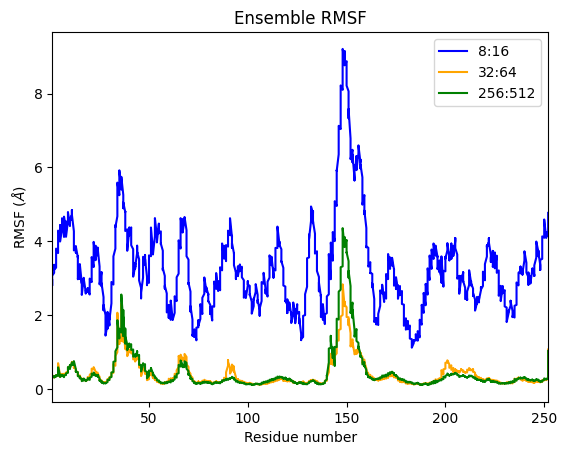

In [ ]:
#@title **Plot RMSFs**

# reorder = False # @param {type:"boolean"}
#new_first_index = "0" #@param {type:"string"}

# if reorder:
#   for resid in c_alphas.resids:
#     resid = c_alphas.resids + int(new_first_index)
# else:
#     resid = c_alphas.resids
resid = c_alphas.resids
#@markdown ###**Residue (c-alpha) range to plot RMSF results:**
first_plotted_residue = min(c_alphas.resids) #@param {type:"string"}
last_plotted_residue = max(c_alphas.resids) #@param {type:"string"}
#@markdown - Defaults to entire protein
#@markdown ---
#@markdown ###**Result analysis:**
#@markdown Generally, we want subsampling parameters that lead to increase fluctuations of **specific residue ranges**
#@markdown - In Abl1, the 8:16 ensemble predicts extreme fluctuations across most of the backbone, likely due to unfolded predictions
#@markdown - In contrast, the 256:512 ensemble predicts significant flucations mostly in the A-Loop and aC-Helix
#@markdown - This analysis points at 256 *(max_seq)* and 512 *(extra_seqs)* to be promising subsampling values for Abl1 kinase core
fig, ax = plt.subplots()
colors = ['blue', 'orange', 'green', 'purple', 'red', 'brown', 'magenta']
for max_seq_v, extra_seq_v, color_v, rmsf_v in zip(max_seq, extra_seq, colors, rmsf_results):
  # Plotting on the passed axes object
  ax.plot(resid, rmsf_v.results.rmsf, color=color_v, label=f'{max_seq_v[:]}:{extra_seq_v[:]}')
  ax.set_xlabel('Residue number')
  ax.set_ylabel('RMSF ($\AA$)')
  ax.set_title('Ensemble RMSF')
  ax.set_xlim(int(first_plotted_residue), int(last_plotted_residue))
  ax.legend()
  plt.savefig(f'{jobname}_{max_seq_v}_{extra_seq_v}_{num_seeds}/{jobname}_{max_seq_v}_{extra_seq_v}_rmsf.png', dpi=600, bbox_inches='tight')


Abl1_8967d max_seq: 8 extra_seq: 16


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

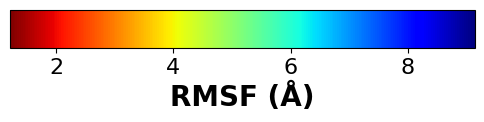

Abl1_8967d max_seq: 32 extra_seq: 64


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

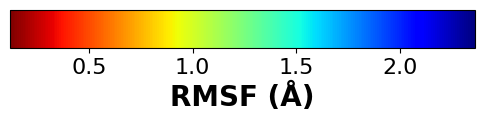

Abl1_8967d max_seq: 256 extra_seq: 512


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

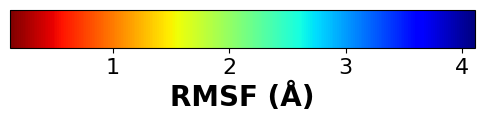

In [ ]:
#@title **Save the RMSF values as custom B factors and display the 3D structure**

import py3Dmol
import matplotlib as mpl

warnings.filterwarnings("ignore")

def pdbRMSF(base_path, analysis_range, max_seq_v, extra_seq_v, pdb_rmsf, sort=True):
    pdb_files = sorted_natural_glob(base_path+'/*.pdb', sort)
    topology_file = pdb_files[0]

    u_getter = loadPredictions(pdb_files, topology_file)
    u_getter.load()
    u = u_getter.get_universe()

    average = align.AverageStructure(u, u, select=analysis_range, ref_frame=0).run()
    ref = average.results.universe
    aligner = align.AlignTraj(u, ref, select=analysis_range, in_memory=True).run()
    c_alphas = u.select_atoms(analysis_range)
    R = rms.RMSF(c_alphas).run()
    rmsf_data = pd.DataFrame(R.rmsf,index=c_alphas.resnums,columns=['RMSF']) #Saving the RMSF value for every aC residue
    rmsf_3d=[]
    protein_write = u.select_atoms("protein")
    protein_write.write("protein_bfactor.pdb")
    u1=mda.Universe("protein_bfactor.pdb","protein_bfactor.pdb")
    u1.add_TopologyAttr('tempfactors') #Initialization of B factors (tempfactors) by MDA in the Universe atoms
    for atom in u1.atoms:
        rmsf_3d.append(rmsf_data.loc[atom.resid,'RMSF']) #A new list of RMSF must be created by ATOM. Our table has this values per aC. We can create a longer list easily
    with mda.Writer(pdb_rmsf, u1) as PDB: #This is the functionality from MDA which allos us to save PDB files.
        for ts in u1.trajectory: #I'll save just the first frame in PDB as snapshot
            u1.atoms.tempfactors = rmsf_3d #This adds the custom B factors to the PDB snapshot
            PDB.write(u1.atoms)
    return R, c_alphas


def show_pdb(pdb_rmsf, R, analysis_range, color="RMSF"):
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_rmsf,'r').read(),'pdb')
  u=mda.Universe(pdb_rmsf,pdb_rmsf)
  c_alphas = u.select_atoms(analysis_range)
  rmsf_data = pd.DataFrame(R.rmsf,index=c_alphas.resnums,columns=['RMSF']) #Saving the RMSF value for every aC residue

  if color == "RMSF":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':min(rmsf_data['RMSF']),'max':max(rmsf_data['RMSF'])}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
      view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  view.zoomTo()
  return view

def bar_color(pdb_rmsf, R, analysis_range):
  u=mda.Universe(pdb_rmsf,pdb_rmsf)
  c_alphas = u.select_atoms(analysis_range)
  rmsf_data = pd.DataFrame(R.rmsf,index=c_alphas.resnums,columns=['RMSF'])
  fig, ax = plt.subplots(figsize=(6, 1))
  fig.subplots_adjust(bottom=0.5)

  cmap = mpl.cm.jet_r
  norm = mpl.colors.Normalize(vmin=min(rmsf_data['RMSF']), vmax=max(rmsf_data['RMSF']))

  cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,norm=norm,orientation='horizontal')
  cb1.set_label('RMSF (Å)',fontsize=20,fontweight='bold')
  cb1.ax.tick_params(labelsize=16)
  plt.show()
  return fig

rmsf_sel = "name CA"

for max_seq_v, extra_seq_v in zip(max_seq, extra_seq):
    print(f'{jobname} max_seq: {max_seq_v} extra_seq: {extra_seq_v}')
    R, c_alphas = pdbRMSF(f'{jobname}_{max_seq_v}_{extra_seq_v}_{num_seeds}/pdb/', rmsf_sel, max_seq_v, extra_seq_v,
                          f'{jobname}_{max_seq_v}_{extra_seq_v}_{num_seeds}/{jobname}_{max_seq_v}_{extra_seq_v}_rmsf.pdb')
    show_pdb(f'{jobname}_{max_seq_v}_{extra_seq_v}_{num_seeds}/{jobname}_{max_seq_v}_{extra_seq_v}_rmsf.pdb', R, rmsf_sel, color="RMSF").show()
    bar_color(f'{jobname}_{max_seq_v}_{extra_seq_v}_{num_seeds}/{jobname}_{max_seq_v}_{extra_seq_v}_rmsf.pdb', R, rmsf_sel).show()

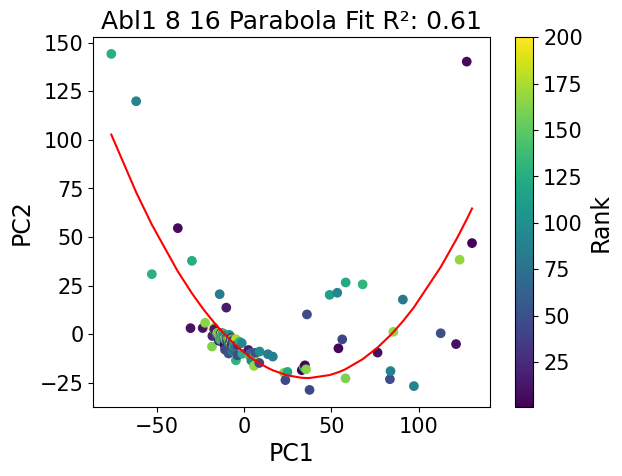

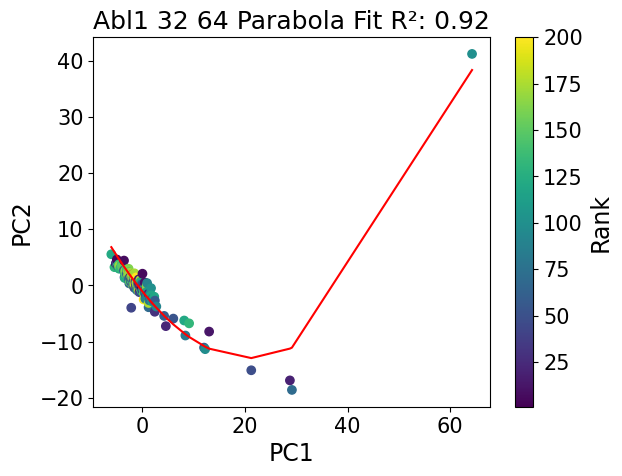

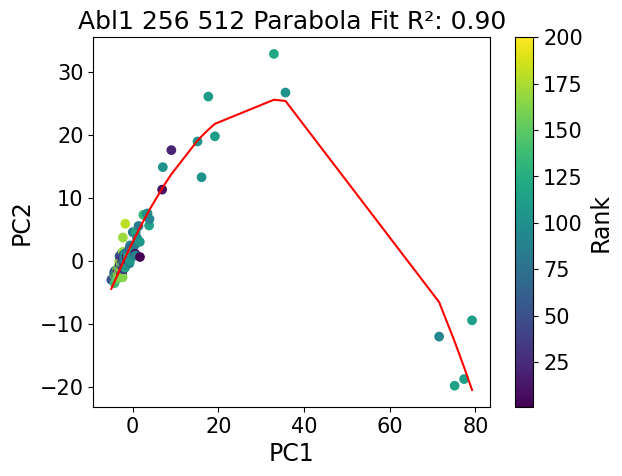

In [ ]:
#@title **Do Principal Component Analysis of each ensemble, plot results, and save trajectory/files**

#@markdown ###**Custom reference for alignment:**

#@markdown By default, selected atoms for the predicted structures will be aligned to the **#1 ranked prediction** (by pLDDT)

#@markdown If you would like to submit a PDB file as reference, check the box below:
use_custom_ref = False #@param {type:"boolean"}
#@markdown - Collab will prompt you to upload the reference after running the cell

#@markdown ----

#@markdown ###**Alignment and PCA selection logic:**

#@markdown *align_sel* defines the atom selection for the alignment that precedes the PCA.
align_sel = "backbone" #@param {type:"string"}

#@markdown - This is system-specific, but for ordered globular proteins with few domains, 'backbone' is a good start

#@markdown *pca_sel* defines the atom selection to use in the PCA (post-alignment).

pca_sel = "resid 130 to 180 and backbone" #@param {type:"string"}

#@markdown - The principal components will be calculated based on the coordinates selected above \
#@markdown - This selection should correspond to the residue ranges you'd like to analyze \
#@markdown - The RMSF calculations in the previous cells provides a quick method to identify flexible regions

#@markdown ----

#@markdown ###**Analyzing results:**

#@markdown The output PCA plots provide basic information about the diversity/coverage of the predicted ensemble. \

#@markdown For systems with two or three predominant conformational modes, a parabola fit is an okay heuristic \
#@markdown to measure ensemble diversity and coverage ("in-between" predictions). \
#@markdown - Broadly speaking, subsampling conditions that lead to ensembles with **fit closer to 1** are more accurate
#@markdown - The range of the PCs also matters - longer ranges with good parabola fits represent larger conformational differences
#@markdown - In the Abl1 example, that would be the 256:512 *max_seq:extra_seq* subsampling parameters
#@markdown - **This is not a one-size-fits-all approach and results should be analyzed carefully and critically!**

#@markdown ----

#@markdown ###**Troubleshooting:**

#@markdown Suggestions for troubleshooting lack or excess of conformational diversity:
#@markdown 1. Re-run predictions with different subsampling parameters
#@markdown - Increase *max_seq* and *extra_seq* if the predicted ensemble is too flexible (unphysical conformations, misfolded loops, etc.)
#@markdown - Decrease *max_seq* and *extra_seq* if the predicted ensemble is too rigid (only one conformation, lack of coverage, etc.)

#@markdown 2. Increase MSA depth (or try other methods for MSA generation such as [jackhmmer](https://www.ebi.ac.uk/Tools/hmmer/search/jackhmmer))

#@markdown 3. Increase the number of seeds

#@markdown 4. Confirm that both the alignment and PCA selections are reasonable for your system

#@markdown 5. If the kernel keeps crashing:
#@markdown - Your MSA might be too deep (not enough RAM, try reducing max_msa_depth)
#@markdown - Your protein might be too large (not enough VRAM, try using a different GPU)
#@markdown ----

#@markdown ###**None of this worked and my predictions still only contain one conformation!**

#@markdown Our approach sometimes fails at predicting conformational changes for specific systems,\
#@markdown especially those resulting from small (involving few backbone atoms) and fast dynamics. \

#@markdown - For these systems and for more involved workflows, we recommend the usage of methods such as [AlphaFold2-RAVE](https://pubs.acs.org/doi/10.1021/acs.jctc.3c00290)

import warnings
warnings.filterwarnings("ignore")

def upload_file():
    if use_custom_ref:
        print("Please upload a PDB file")
        uploaded = files.upload()
        if len(uploaded) != 1:
            print("Please upload only one file")
            return None
        else:
            filename = next(iter(uploaded))
            print(f"Uploaded reference: {filename}")
            return filename
    else:
        print("No file will be uploaded.")
        return None

def parabola(x, a, b, c):
    return a * x**2 + b * x + c

def pca_from_ensemble(path,
                      align_range,
                      analysis_range,
                      max_seq_v,
                      extra_seq_v,
                      use_custom_ref,
                      custom_ref_path,
                      dcd_traj,
                      pdb_ref,
                      pca_png,
                      plot=True,
                      sort=True):

    pdb_files = sorted_natural_glob(path + '/*.pdb', sort)
    topology_file = pdb_files[0]

    u_getter = loadPredictions(pdb_files, topology_file)
    u_getter.load()
    u = u_getter.get_universe()
    u_ref = u

    if use_custom_ref:
      u_ref = mda.Universe(custom_ref_path)

    aligner = align.AlignTraj(u, u_ref, select=align_sel,
                              in_memory=True).run()

    u1 = mda.Universe(topology_file, topology_file)
    with mda.Writer(dcd_traj, u.select_atoms("all").n_atoms) as W:
      for ts in u.trajectory[::]:
          W.write(u.select_atoms("all"))
    whole = u1.select_atoms("all")
    whole.write(pdb_ref)


    ensemble_pca = pca.PCA(u, select=analysis_range,
                           align=False, mean=None,
                           n_components=None).run()

    atomsel = u.select_atoms(analysis_range)

    # Transform and select only the first two components
    transformed_pca = ensemble_pca.transform(atomsel, n_components=3)
    pca_df = pd.DataFrame(transformed_pca, columns=['PC1', 'PC2', 'PC3'])
    popt, pcov = curve_fit(parabola, pca_df['PC1'], pca_df['PC2'])
    pca_df['PC2_fit'] = parabola(pca_df['PC1'], *popt)
    r2 = r2_score(pca_df['PC2'], pca_df['PC2_fit'])
    pca_df['AF2 Rank'] = range(1, len(pca_df) + 1)
    pca_df.sort_values('PC1', inplace=True)

    if plot:
      # Define the colormap
      cmap = cm.get_cmap('viridis')

      # Create a scatter plot with colors based on 'Rank'
      scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['AF2 Rank'], cmap=cmap)

      # Adding the parabola fit line
      plt.plot(pca_df['PC1'], pca_df['PC2_fit'], color='red')

      # Adding the title and adjusting font size
      plt.title(f"{jobname.split('_')[0]} {max_seq_v} {extra_seq_v} Parabola Fit R²: {r2:.2f}", fontsize=18)

      # Setting the tick parameters
      plt.tick_params(axis='both', which='major', labelsize=15)

      # Setting the labels and their font sizes
      plt.xlabel('PC1', fontsize=17)
      plt.ylabel('PC2', fontsize=17)

      # Adding a color bar
      cbar = plt.colorbar(scatter)
      cbar.set_label('Rank', fontsize=17)
      cbar.ax.tick_params(labelsize=15)

      plt.savefig(pca_png, dpi=600, bbox_inches='tight')

      # Show the plot
      plt.show()

    return pca_df

custom_ref = None
if use_custom_ref:
   custom_ref = upload_file()

pca_dfs = []
for max_seq_v, extra_seq_v in zip(max_seq, extra_seq):
  pred_df = pca_from_ensemble(f'{jobname}_{max_seq_v}_{extra_seq_v}_{num_seeds}/pdb', align_sel, pca_sel, max_seq_v, extra_seq_v, use_custom_ref, custom_ref,
                              f'{jobname}_{max_seq_v}_{extra_seq_v}_{num_seeds}/{jobname}_{max_seq_v}_{extra_seq_v}_traj.dcd',
                              f'{jobname}_{max_seq_v}_{extra_seq_v}_{num_seeds}/{jobname}_{max_seq_v}_{extra_seq_v}_ref.pdb',
                              f'{jobname}_{max_seq_v}_{extra_seq_v}_{num_seeds}/{jobname}_{max_seq_v}_{extra_seq_v}_pca.png')
  pca_dfs.append(pred_df)

In [ ]:
#@title **Load, view and check the trajectories**

#@markdown ###**Ensemble selection and animation parameters**

#@markdown Input the *max_seq*, *extra_seq* parameters for the previously predicted ensemble you would like to visualize
max_seq_v = "256" #@param ["2048", "1024", "512", "256", "128", "64", "32", "16", "8", "4", "2"]
extra_seq_v = "512" #@param ["2048", "1024", "512", "256", "128", "64", "32", "16", "8", "4", "2"]

#@markdown Set the stride of the animation (how many frames to include) \
#@markdown - Increase this value if animation is taking very long to render
stride_animation = 10 #@param

#@markdown This might take a few minutes.

u = mda.Universe(f'{jobname}_{max_seq_v}_{extra_seq_v}_{num_seeds}/{jobname}_{max_seq_v}_{extra_seq_v}_ref.pdb', f'{jobname}_{max_seq_v}_{extra_seq_v}_{num_seeds}/{jobname}_{max_seq_v}_{extra_seq_v}_traj.dcd')
num_frames = len(u.trajectory)

warnings.filterwarnings('ignore')

#py3dmol functions
class Atom(dict):
  def __init__(self, line):
    self["type"] = line[0:6].strip()
    self["idx"] = line[6:11].strip()
    self["name"] = line[12:16].strip()
    self["resname"] = line[17:20].strip()
    self["resid"] = int(int(line[22:26]))
    self["x"] = float(line[30:38])
    self["y"] = float(line[38:46])
    self["z"] = float(line[46:54])
    self["sym"] = line[76:78].strip()

  def __str__(self):
    line = list(" " * 80)
    line[0:6] = self["type"].ljust(6)
    line[6:11] = self["idx"].ljust(5)
    line[12:16] = self["name"].ljust(4)
    line[17:20] = self["resname"].ljust(3)
    line[22:26] = str(self["resid"]).ljust(4)
    line[30:38] = str(self["x"]).rjust(8)
    line[38:46] = str(self["y"]).rjust(8)
    line[46:54] = str(self["z"]).rjust(8)
    line[76:78] = self["sym"].rjust(2)
    return "".join(line) + "\n"

class Molecule(list):
  def __init__(self, file):
    for line in file:
      if "ATOM" in line or "HETATM" in line:
        self.append(Atom(line))

    def __str__(self):
      outstr = ""
      for at in self:
        outstr += str(at)
      return outstr

# Write out frames for animation
protein = u.select_atoms('not (resname WAT)')
i = 0
for ts in u.trajectory[0:len(u.trajectory):int(stride_animation)]:
    if i > -1:
        with mda.Writer('' + str(i) + '.pdb', protein.n_atoms) as W:
            W.write(protein)
    i = i + 1
# Load frames as molecules
molecules = []
for i in range(int(len(u.trajectory)/int(stride_animation))):
    with open('' + str(i) + '.pdb') as ifile:
        molecules.append(Molecule(ifile))

models = ""
for i in range(len(molecules)):
  models += "MODEL " + str(i) + "\n"
  for j,mol in enumerate(molecules[i]):
    models += str(mol)
  models += "ENDMDL\n"
#view.addModelsAsFrames(models)

# Animation
view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(models)
for i, at in enumerate(molecules[0]):
    default = {"cartoon": {'color': 'spectrum'}}
    view.setStyle({'model': -1, 'serial': i+1}, at.get("pymol", default))

view.zoomTo()
view.animate({'loop': "forward"})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
#@title **Pack and upload the results to Google Drive or download them directly.**

#@markdown ###**Download troubleshooting**:
#@markdown If you are having issues downloading the result archive, try disabling your adblocker.

#@markdown If that fails click, on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" .
import subprocess

results_zip = f"{jobname}.result.zip"

if os.path.exists(results_zip):
  os.remove(results_zip)
else:
  pass

for i, (max_seq_v, extra_seq_v) in enumerate(zip(max_seq, extra_seq)):
    globals()[f'results_{i+1}'] = f'{jobname}_{max_seq_v}_{extra_seq_v}_{num_seeds}'

results_files = " ".join([globals()[f'results_{j+1}'] for j in range(3)])  # Adjust range as necessary
zip_command = f"zip -r {results_zip} {results_files} {jobname}"

# Using subprocess.run for better practice
subprocess.run(zip_command, shell=True, check=True)

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': results_zip})
  uploaded.SetContentFile(results_zip)
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")
else:
  files.download(f"{jobname}.result.zip")

Uploaded Abl1_8967d.result.zip to Google Drive with ID 1weEBwZzgcFECq-q_XHtcMQV3cVW1yKIY
